## Интеллектуальный анализ данных – весна 2025
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать с усеченным датасетом `Palmer Penguins`, содержащим информацию о характеристиках трех видов пингвинов: `Adelie`, `Chinstrap` и `Gentoo`:



*   Species — вид пингвина (целевая переменная).
*   Island — остров, на котором была сделана запись.
*   Clutch Completion — завершенность кладки яиц.
*   Date Egg — закодированная дата откладки яиц (число дней от самой ранней даты в данных).
*   Culmen Length (mm) — длина клюва.
*   Culmen Depth (mm) — глубина клюва.
*   Flipper Length (mm) — длина ласт.
*   Body Mass (g) — масса тела в граммах.
*   Sex — пол особи.
*   Delta 15 N (o/oo) и Delta 13 C (o/oo) — изотопные значения, характеризующие пищевые предпочтения.

Описание полного набора данных и дополнительную информацию о проекте можно найти [здесь](https://allisonhorst.github.io/palmerpenguins/index.html) и [здесь](https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data?resource=download).

![Palmer Penguins](https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png)



In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [230]:
data = pd.read_csv('penguins_data.csv')
data.head(10)

,Species,Island,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,Chinstrap,Dream,Yes,382,50.9,19.1,196.0,3550.0,MALE,10.02372,-24.86594
1,Chinstrap,Dream,Yes,741,45.2,17.8,198.0,3950.0,FEMALE,8.88942,-24.49433
2,Gentoo,Biscoe,Yes,744,46.5,13.5,210.0,4550.0,FEMALE,7.99530,-25.32829
3,Chinstrap,Dream,Yes,10,45.2,16.6,191.0,3250.0,FEMALE,9.62357,-24.78984
4,Gentoo,Biscoe,Yes,13,48.4,14.4,203.0,4625.0,FEMALE,8.16582,-26.13971
5,Gentoo,Biscoe,Yes,22,48.1,15.1,209.0,5500.0,MALE,8.45738,-26.22664
6,Gentoo,Biscoe,Yes,13,51.1,16.5,225.0,5250.0,MALE,8.20660,-26.36863
7,Gentoo,Biscoe,No,392,42.7,13.7,208.0,3950.0,FEMALE,8.14567,-26.59467
8,Adelie,Biscoe,Yes,14,39.6,20.7,191.0,3900.0,FEMALE,8.80967,-26.78958
9,Gentoo,Biscoe,Yes,735,46.1,13.2,211.0,4500.0,FEMALE,7.99300,-25.51390


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные признаки? Если да, то закодируйте их самым оптимальным способом. Аргументируйте свой выбор.

In [148]:
# проверим, сколько пропусков и где (просто интересно)
missing_values = data.isnull().sum()
missing_values

Species                 0
Island                  0
Clutch Completion       0
Date Egg                0
Culmen Length (mm)      2
Culmen Depth (mm)       2
Flipper Length (mm)     2
Body Mass (g)           2
Sex                    10
Delta 15 N (o/oo)      14
Delta 13 C (o/oo)      13
dtype: int64

In [231]:
# удаляем все пропущенные значения. если после этого запустить предыдущую ячейку, получим нули везде как доказательство 
# успешно проделанной операции.
data = data.dropna()

In [232]:
# теперь посмотрим на категориальные признаки, чтобы решить, как кодировать

categorical_columns = ['Island', 'Clutch Completion', 'Sex']
unique_values = {col: data[col].unique().tolist() for col in categorical_columns}
print("Уникальные значения:")
print(unique_values)
# видно, что признаков максимум три варианта, значит One-hot encoding можно не использовать, чтобы не усложнять датасет.
# но для начала удалим ненужные поля в категории Sex (nan, ".")
data['Sex'] = data['Sex'].replace('.', np.nan)
data = data.dropna(subset=['Sex'])

# теперь сопоставим каждому уникальному значению число 
mappings = {col: {value: idx for idx, value in enumerate(unique_values[col])} for col in unique_values}

# и применим это кодирование к датасету 
for col, mapping in mappings.items():
    data[col] = data[col].map(mapping)

print("\ndata после кодирования:")
print(data.head(10))

Уникальные значения:
{'Island': ['Dream', 'Biscoe', 'Torgersen'], 'Clutch Completion': ['Yes', 'No'], 'Sex': ['MALE', 'FEMALE', '.']}

data после кодирования:
     Species  Island  Clutch Completion  Date Egg  Culmen Length (mm)  \
0  Chinstrap       0                  0       382                50.9   
1  Chinstrap       0                  0       741                45.2   
2     Gentoo       1                  0       744                46.5   
3  Chinstrap       0                  0        10                45.2   
4     Gentoo       1                  0        13                48.4   
5     Gentoo       1                  0        22                48.1   
6     Gentoo       1                  0        13                51.1   
7     Gentoo       1                  1       392                42.7   
8     Adelie       1                  0        14                39.6   
9     Gentoo       1                  0       735                46.1   

   Culmen Depth (mm)  Flipper Length 

Целевую категориальную переменную закодируйте в ординальном порядке: Chinstrap = 0, Gentoo = 1, Adelie = 2. Можно воспользоваться [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

Теперь сохраним информацию о признаках в переменную
`X`, а о целевой переменной – в переменную `y`.

In [233]:
data['Species'].unique().tolist()

['Chinstrap', 'Gentoo', 'Adelie']

In [234]:
from sklearn.preprocessing import OrdinalEncoder

categories = [['Chinstrap', 'Gentoo', 'Adelie']]
encoder = OrdinalEncoder(categories=categories)
data['Species'] = encoder.fit_transform(data[['Species']]).flatten()

X = data.drop('Species', axis=1)
y = data['Species']


In [235]:
y

0      0.0
1      0.0
2      1.0
3      0.0
4      1.0
      ... 
339    0.0
340    2.0
341    2.0
342    1.0
343    2.0
Name: Species, Length: 324, dtype: float64

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

In [236]:
from sklearn.model_selection import train_test_split
# фиксируем генератор случайных чисел на 42
np.random.seed(15320)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=15320)

# использование аргумента stratify очень важно, 
# потому что помогает зафиксировать пропорции классов в тренировочной и тестовой выборках
# это способствует улучшению качества модели. ведь если на тренировочной выборке 
# она "не видела" какой-то класс, но вряд ли сможет корректно распознать его на тестовой (просто пример)


**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака:  `Flipper Length (mm)` и `Body Mass (g)`  – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [237]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

features = ['Flipper Length (mm)', 'Body Mass (g)']
X_train_selected = X_train[features]
X_test_selected = X_test[features]

# масштабируем
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

n_neighbors = [1, 3, 5, 10, 15, 25]

results = []
for k in n_neighbors:
    # создаем модель
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean') # явно указываем, какая метрика нужна          
    knn.fit(X_train_scaled, y_train)
    # делаем предсказания
    y_train_pred = knn.predict(X_train_scaled)
    y_test_pred = knn.predict(X_test_scaled)
    # считаем точность
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    results.append((k, train_acc, test_acc))

print("NN\tTrain\tTest")
for k, train, test in results:
    print(f"{k}\t{train:.2f}\t\t{test:.2f}")


NN	Train	Test
1	0.99		0.69
3	0.92		0.71
5	0.89		0.74
10	0.83		0.79
15	0.84		0.78
25	0.85		0.78


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

In [16]:
!pip install mlxtend


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [17]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

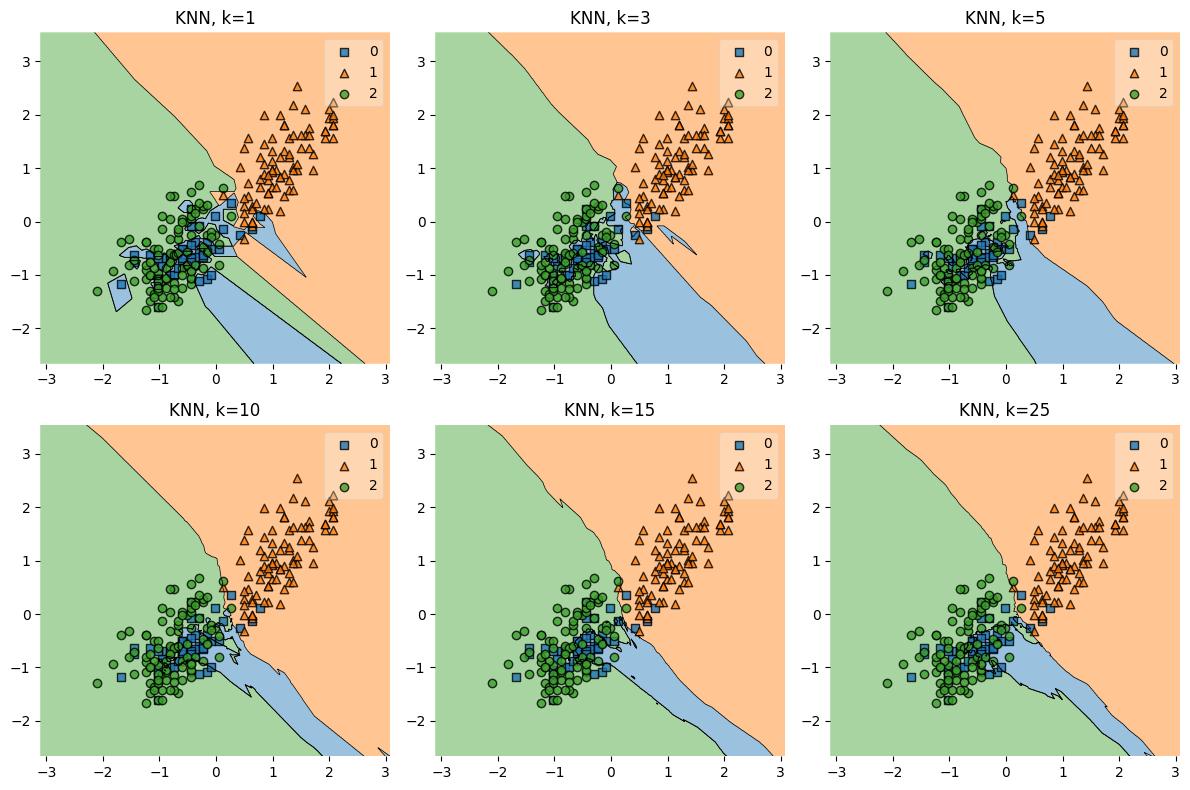

In [27]:
import itertools
from mlxtend.plotting import plot_decision_regions
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec

features = ['Flipper Length (mm)', 'Body Mass (g)']
X_train_selected = X_train[features].values  # приводим к numpy формату
y_train_np = y_train.astype(np.int_).values  # преобразуем в int

# обязательно масштабируем 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)

n_neighbors = [1, 3, 5, 10, 15, 25]

# рисуем графики
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 3) 

for idx, k in enumerate(n_neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train_scaled, y_train_np) 
    
    ax = plt.subplot(gs[idx]) 
    plot_decision_regions(X_train_scaled, y_train_np, clf=knn, legend=1)
    
    plt.title(f'KNN, k={k}')

plt.tight_layout()
plt.show()


**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

Я не использовала itertools.product(), потому что у меня меняется только один параметр - число соседей. А itertools.product() 
нужен в случаях, если меняется два и более параметров. Например, если нужно бы было рассматривать результаты работы
разных моделей (knn, svc) при разном числе соседей.

Анализируя результат в адаче 1.3 можно сделать вывод о том, что при увеличении числа соседей
может произойти такая ситуация, что результат на тренировочной выборке будет ухудшаться, а на тестовой - улучшаться, 
хотя при минимальных k все наоборот - результат на тренировочной выборке
значительно лучше тестовой, что логично. 

Задание 1.5 помогает визуально представить результаты. Видно, что с увеличением числа соседей
области становятся более четко ограниченными. То есть границы становятся менее хаотичными и практически пропадают
ситуации, когда среди одной области появляется часть другой.

Рассматривая все эти результаты, делаем вывод, что лучше всего брать число соседей, равное 5, так как при этих значениях ошибка на тесте
не такая большая, как при k = 1 и в то же время ошибка на train не такая большая, как при k = 25. Также это лучше, чем k = 10 
(хотя и показатели совпадают) с точни зрения вычислительных затрат. При таком k асимптотика меньше в 2 раза, чем при k = 10, 
что очень хорошо!

О переобучении модели явно говорят такие случаи, когда на решающей поверхности есть много "кусочнов" других областей внутри 
какой-то другой. Например, при k = 1 есть случаи, когда из-за одного объекта классификатор
перекрашивает небольшую область внутри другого класса в другой цвет.

### Задание 2. KNN своими руками. 2,5 балла

**Задача 2.1 (2 балла)** В данном задании мы попробуем реализовать алгоритм KNN своими руками, делать мы будем KNN именно для классификации.

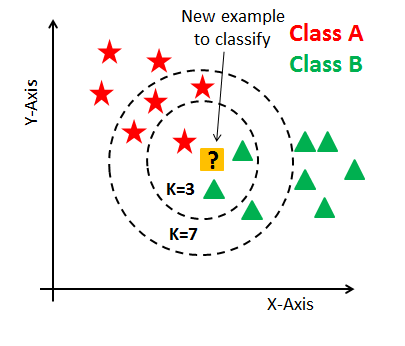

Рекомендации по реализации:
- Используйте `numpy` для представления данных в виде массивов, чтобы минимизировать преобразования.
- Избегайте циклов по всем объектам, по возможности используйте векторизированные операции.
- Обратите внимание на методы [np.linalg.norm()](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) и [np.argsort()](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html), а также на класс `collections.Counter`.
- Особый плюс, если учтёте обработку возможных ошибок.

In [156]:
import numpy as np
from collections import Counter

class KNN:
    def __init__(self, k:int):
        if not isinstance(k, int) or k <= 0:
            raise ValueError("Число соседей k должно быть положительным целым числом!")
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        # в knn просто запоминаем обучающую выборку
        X, y = np.array(X), np.array(y)
        
        if len(X) == 0 or len(y) == 0:
            raise ValueError("Обучающая выборка X и y не должна быть пустой!")

        if len(X) != len(y):
            raise ValueError("Размеры X и y должны совпадать!")
            
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        # (⌒_⌒;)

    def predict(self, X):
        if self.X_train is None or self.y_train is None:
            raise ValueError("Сначала вызовите fit(), прежде чем делать предсказания!")

        X = np.array(X) 
        if len(X) == 0:
            raise ValueError("Массив X для предсказания не должен быть пустым!")

        if self.k > len(self.X_train):
            raise ValueError(f"k ({self.k}) не может быть больше количества объектов в обучающей выборке ({len(self.X_train)})!")

        predictions = []
        for x in X:
            # считаем расстояния до всех объектов обучающей выборки
            distances = np.linalg.norm(self.X_train - x, axis=1) 
            # находим k ближайших соседей
            k_neighbors_indices = np.argsort(distances)[:self.k] # т.е. берем их индексы
            # берем их классы
            k_neighbor_labels = self.y_train[k_neighbors_indices]
            # и определяем самый частый класс
            most_common = sorted(Counter(k_neighbor_labels).most_common(), key=lambda x: (-x[1], x[0]))[0][0]
            # добавялем самый частый класс в массив ответов-предсказаний
            predictions.append(most_common)

        return np.array(predictions)

    def count_distance(self, x, y):
      # считаем евклидово расстояние между двумя точками
      # ヽ(♡‿♡)ノ
      return np.linalg.norm(x - y)

In [157]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [158]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

**Задача 2.2 (0.5 балла)** Протестируйте ваш алгоритм на данных о пингвинах. Выведите лучший получившийся результат на тестовой выборке.

In [194]:
features = ['Flipper Length (mm)', 'Body Mass (g)']
X_train_selected = X_train[features]
X_test_selected = X_test[features]

# масштабируем
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

n_neighbors = [1, 3, 5, 10, 15, 25]

results = []
for k in n_neighbors:
    # создаем модель
    knn = KNN(k)        
    knn.fit(X_train_scaled, y_train)
    # делаем предсказания
    y_train_pred = knn.predict(X_train_scaled)
    y_test_pred = knn.predict(X_test_scaled)
    # считаем точность
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    results.append((k, train_acc, test_acc))

print("NN\tTrain\tTest")
for k, train, test in results:
    print(f"{k}\t{train:.2f}\t\t{test:.2f}")


NN	Train	Test
1	0.99		0.70
3	0.91		0.72
5	0.89		0.74
10	0.83		0.80
15	0.84		0.77
25	0.85		0.78


Лучшее k: 25 с точностью 0.89 на test. (randomseed = 15321)

Лучшее k: 3 с точностью 0.9898 на test.


### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [240]:
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [106]:
missing_values = data.isnull().sum().sum()
missing_values
# значит, пропущенный хначений нет
# здесь бессмысленный столбец Unnamed: 0

0

In [241]:
data = data.drop(columns=['Unnamed: 0'])

In [242]:
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**Задача 3.2 (0.2 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Постройте матрицу корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки имеют наибольшую корреляцию с целевой переменной?

In [243]:
data.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

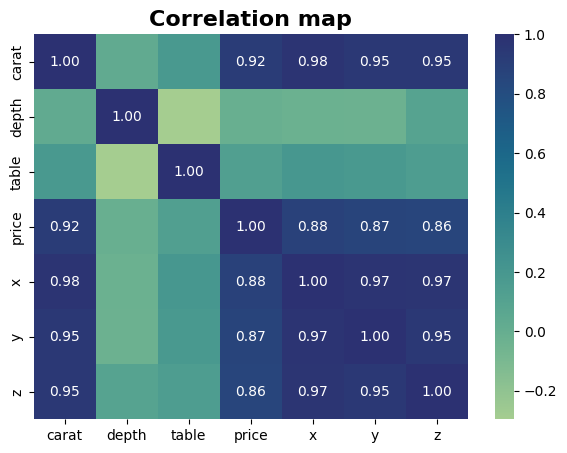

In [244]:
import seaborn as sns
data_optimised = data.drop(columns=['cut', 'color', 'clarity'])
plt.figure(figsize=(7, 5)) 

correlation_matrix = data_optimised.corr()

ax = sns.heatmap(correlation_matrix, cmap="crest", annot=True, fmt="0.2f")
for t in ax.texts:
    if float(t.get_text()) > 0.4 or float(t.get_text()) <= -0.4:
        t.set_text(t.get_text())
    else:
        t.set_text("")
        
plt.title("Correlation map", fontweight='bold', fontsize=16)
plt.show() 

Видно, что наибольшую корреляцию с целевой переменной
имеют признаки carat, x, y, z.

**Задача 3.3 (0.2 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные признаки методом OneHot-кодирования (`pd.get_dummies()` или `OneHotEncoder` из `sklearn`).

In [126]:
data_encoded = pd.get_dummies(data, columns=['cut', 'color', 'clarity'], drop_first=True)

In [127]:
data_encoded.columns

Index(['carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'cut_Good',
       'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_E', 'color_F',
       'color_G', 'color_H', 'color_I', 'color_J', 'clarity_IF', 'clarity_SI1',
       'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1',
       'clarity_VVS2'],
      dtype='object')

**Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3. Не забудьте про параметр `stratify`.

In [135]:
X_diamonds = data_encoded.drop('price', axis=1)
y_diamonds = data_encoded['price']

In [138]:
print("X_diamonds shape:", X_train_diamonds.shape)
print("y_diamonds shape:", X_test_diamonds.shape)

X_diamonds shape: (37758, 23)
y_diamonds shape: (16182, 23)


In [136]:
np.random.seed(142)
X_train_diamonds, X_test_diamonds, y_train_diamonds, y_test_diamonds = train_test_split(X_diamonds, y_diamonds, test_size=0.3,  random_state=142)

**Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче стандартизируйте вещественные признаки в тренировочной и тестовой выборках с помощью `StandardScaler`.

Объясните, как это повлияет на интерпретацию коэффициентов линейной регрессии.

In [140]:
numeric_features = ['carat', 'depth', 'table', 'x', 'y', 'z']  

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_diamonds[numeric_features])
X_test_scaled = scaler.transform(X_test_diamonds[numeric_features])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_features, index=X_train_diamonds.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_features, index=X_test_diamonds.index)

print(X_train_scaled.head())

          carat     depth     table         x         y         z
38992 -0.865021 -1.575373  0.242559 -0.887486 -0.839869 -1.001575
52673 -0.209405  0.804129  2.042685 -0.093372 -0.146077 -0.029447
53908 -0.209405 -0.385622 -0.207472 -0.048758 -0.007318 -0.071713
30175 -0.886170 -0.455607 -1.107535 -0.941022 -0.883231 -0.945219
15141  0.467359  0.594173  0.692591  0.620440  0.565060  0.660905


In [141]:
# объединяем категориальные признаки обратно
categorical_features = ['cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good', 
                        'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 
                        'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 
                        'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2']

X_train_final = pd.concat([X_train_scaled, X_train_diamonds[categorical_features]], axis=1)
X_test_final = pd.concat([X_test_scaled, X_test_diamonds[categorical_features]], axis=1)

# проверяем
print(X_train_final.head())

          carat     depth     table         x         y         z  cut_Good  \
38992 -0.865021 -1.575373  0.242559 -0.887486 -0.839869 -1.001575     False   
52673 -0.209405  0.804129  2.042685 -0.093372 -0.146077 -0.029447     False   
53908 -0.209405 -0.385622 -0.207472 -0.048758 -0.007318 -0.071713     False   
30175 -0.886170 -0.455607 -1.107535 -0.941022 -0.883231 -0.945219     False   
15141  0.467359  0.594173  0.692591  0.620440  0.565060  0.660905     False   

       cut_Ideal  cut_Premium  cut_Very Good  ...  color_H  color_I  color_J  \
38992      False        False           True  ...    False    False    False   
52673      False         True          False  ...    False    False    False   
53908      False        False           True  ...    False    False    False   
30175       True        False          False  ...     True    False    False   
15141      False         True          False  ...    False    False    False   

       clarity_IF  clarity_SI1  clarity_SI2 

После стандартизации коэффициенты будут показывать важность каждого признака для
результата (нашего таргета). И их можно будет сравнивать между категориями и 
понять, какой признак вносит наибольший вклад, а какой нет.
Если бы не стандартизация, сложно было бы оценить это по коэффициентам.
Пример из лекции: изменение площади квартиры на м^2 в центре Москвы очень меняет её цену.
Но числовые значения метров не соответствуют рублям (не одного масштаба), поэтому в будущем
это может привести к проблемам в оценке модели, вычислении MSE и многим другим проблемам.

**Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [143]:
y_train_diamonds.describe()

count    37758.000000
mean      3936.625139
std       3980.370465
min        326.000000
25%        956.000000
50%       2422.000000
75%       5335.000000
max      18818.000000
Name: price, dtype: float64

In [144]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# инициализируем модель линейной регрессии
lin_reg = LinearRegression()

# обучаем
lin_reg.fit(X_train_final, y_train_diamonds)

# предсказываем на train
y_train_pred = lin_reg.predict(X_train_final)

# предсказываем на test
y_test_pred = lin_reg.predict(X_test_final)

# рассчитываем MSE на train
train_mse = mean_squared_error(y_train_diamonds, y_train_pred)

# рассчитываем MSE на test
test_mse = mean_squared_error(y_test_diamonds, y_test_pred)

print(f"MSE train: {train_mse:.4f}")
print(f"MSE test: {test_mse:.4f}")


MSE train: 1261686.6251
MSE test: 1312646.2419


Сначала может показаться, что в чем-то ошибка, ведь значение MSE огромное - больше миллиона!
Но если посмотреть через describe на цены, то станет понятно, почему.
Тем более что целевая переменная не была нормирована.

**Задача 3.7 (0.3 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [203]:
coeff = lin_reg.coef_
coeff


array([ 5.39233279e+03, -9.61162826e+01, -6.48457471e+01, -1.19021903e+03,
       -4.81077087e+00, -2.97880787e+01,  5.67961811e+02,  8.04509527e+02,
        7.45028254e+02,  6.99019990e+02, -2.11920196e+02, -2.72763202e+02,
       -4.79750230e+02, -9.74594235e+02, -1.47269231e+03, -2.36422712e+03,
        5.27385865e+03,  3.61103210e+03,  2.64134577e+03,  4.52810124e+03,
        4.22805850e+03,  4.93601925e+03,  4.90139783e+03])

In [205]:
features = ['carat', 'depth', 'table', 'x', 'y', 'z', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good',
            'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_IF', 'clarity_SI1',
            'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2']

# датафрейм, чтобы удобнее смотреть
coeff_df = pd.DataFrame({
    'Feature': features, 
    'Coefficient': coeff
})
# чтобы по нему отсортировать
coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].abs()

coeff_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False)

coeff_df


,Feature,Coefficient,Abs_Coefficient
0,carat,5392.332793,5392.332793
16,clarity_IF,5273.858654,5273.858654
21,clarity_VVS1,4936.019248,4936.019248
22,clarity_VVS2,4901.397833,4901.397833
19,clarity_VS1,4528.101238,4528.101238
20,clarity_VS2,4228.058497,4228.058497
17,clarity_SI1,3611.032102,3611.032102
18,clarity_SI2,2641.345768,2641.345768
15,color_J,-2364.227123,2364.227123
14,color_I,-1472.692305,1472.692305


Вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных:
    carat, x, depth.

**Задача 3.8 (0.5 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, установив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [208]:
# просто проверка размерностей, чтобы исправить ошибки
print(X_train_final.shape) 
print(X_test_final.shape)   
print(y_train_diamonds.shape)  
print(y_test_diamonds.shape)  

(37758, 23)
(16182, 23)
(37758,)
(16182,)


In [211]:
from sklearn.linear_model import Lasso, Ridge

alpha = 10
lasso = Lasso(alpha=alpha, random_state=42)
ridge = Ridge(alpha=alpha, random_state=42)

# обучаемся
lasso.fit(X_train_final, y_train_diamonds)
ridge.fit(X_train_final, y_train_diamonds)

y_train_lasso_pred = lasso.predict(X_train_final)
y_test_lasso_pred = lasso.predict(X_test_final)

y_train_ridge_pred = ridge.predict(X_train_final)
y_test_ridge_pred = ridge.predict(X_test_final)

# считаем MSE
mse_train_lasso = mean_squared_error(y_train_diamonds, y_train_lasso_pred)
mse_test_lasso = mean_squared_error(y_test_diamonds, y_test_lasso_pred)

mse_train_ridge = mean_squared_error(y_train_diamonds, y_train_ridge_pred)
mse_test_ridge = mean_squared_error(y_test_diamonds, y_test_ridge_pred)

print(f'Lasso - MSE на train: {mse_train_lasso:.2f}')
print(f'Lasso - MSE на test: {mse_test_lasso:.2f}')
print(f'Ridge - MSE на train: {mse_train_ridge:.2f}')
print(f'Ridge - MSE на test: {mse_test_ridge:.2f}')

print("\nКоэффициенты Lasso:")
print(lasso.coef_)

print("\nКоэффициенты Ridge:")
print(ridge.coef_)

# Для сравнения, посмотрим на коэффициенты линейной регрессии без регуляризации
# (из пред. шага)
print("\nКоэффициенты линейной регрессии без регуляризации:")
print(lin_reg.coef_)


Lasso - MSE на тренировочной выборке: 1488637.53
Lasso - MSE на тестовой выборке: 1562468.46
Ridge - MSE на тренировочной выборке: 1265656.34
Ridge - MSE на тестовой выборке: 1318804.76

Коэффициенты Lasso:
[ 4.81856735e+03 -1.54729580e+02 -1.07751541e+02 -7.70925340e+02
 -0.00000000e+00 -4.16615040e+00 -0.00000000e+00  1.55061967e+02
  7.28232003e+01  6.84747135e+01  0.00000000e+00 -0.00000000e+00
 -1.11724046e+02 -5.95523180e+02 -1.00422924e+03 -1.77889598e+03
  1.28390936e+03  0.00000000e+00 -8.13948900e+02  8.23822723e+02
  5.92846176e+02  1.13759612e+03  1.16597360e+03]

Коэффициенты Ridge:
[ 5.33990179e+03 -9.88764675e+01 -6.73995654e+01 -1.15036615e+03
 -4.45638099e+00 -2.98913528e+01  5.88853233e+02  8.31241365e+02
  7.68425766e+02  7.27224061e+02 -2.00858785e+02 -2.60709700e+02
 -4.62449842e+02 -9.57417160e+02 -1.44804990e+03 -2.32913672e+03
  4.68865078e+03  3.07100248e+03  2.10885786e+03  3.97892528e+03
  3.68444871e+03  4.37323885e+03  4.34571557e+03]

Коэффициенты линейной

Сильно ли уменьшились веса? 
Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

**Вывод:** проблема мультиколлинеарности действительно существовала
    в изначальной регрессии, ведь веса после регуляризации двумя разными методами поменялись в обоих случаях и в лучшую сторону.
    Так, коэф. в Lasso явно уменьшились, а в 5 признаках вовсе занулились. Таким образом этот метод
    регуляризации помогает упростить модель и сделать её более обобщающей. При Ridge коэф. тоже уменьшились, но не занулились окончательно,
    потому что данный метод регуляризации направлен на то, чтобы все-таки сохранить информацию о всех имеющихся признаках.
    Судя по значениям MSE Lasso выдала самое худшее качество (в сравнении с Ridge и изначальной регрессией).
    Это неудивительно, ведь оно просто занулило некоторые признаки. Хотя никто не отрицает, что на валидационной выборке
    оно может выдать более хороший результат, чем два других способа, так как обладает наилучшей обобщаемостью.
    MSE на Ridge практически не отличается от ранее вычисленной MSE, так что пока это лучший способ регуляризации,
    ведь и ошибка сильно не ухудшилась, и веса немного уменьшились.
  

**Задача 3.9 (0.5 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод сильнее снижает норму коэффициентов? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

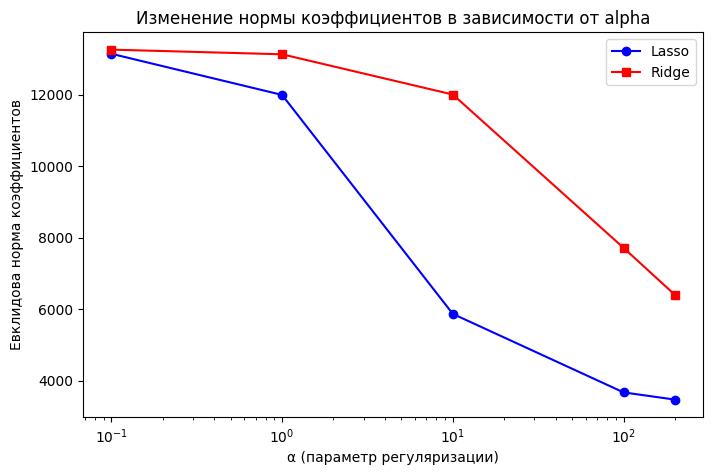

In [214]:
alpha_values = [0.1, 1, 10, 100, 200]
# тут будем хранить коэфф.
lasso_norms = []
ridge_norms = []

# обучаемся на разных alpha
for alpha in alpha_values:
    lasso = Lasso(alpha=alpha)
    ridge = Ridge(alpha=alpha)

    lasso.fit(X_train_final, y_train_diamonds) 
    ridge.fit(X_train_final, y_train_diamonds)  
    # считаем нормы
    lasso_norms.append(np.linalg.norm(lasso.coef_)) 
    ridge_norms.append(np.linalg.norm(ridge.coef_))  

plt.figure(figsize=(8, 5))
plt.plot(alpha_values, lasso_norms, marker='o', label='Lasso', color='blue')
plt.plot(alpha_values, ridge_norms, marker='s', label='Ridge', color='red')
plt.xlabel("α (параметр регуляризации)")
plt.ylabel("Евклидова норма коэффициентов")
plt.xscale("log")  
plt.legend()
plt.title("Изменение нормы коэффициентов в зависимости от alpha")
plt.show()


Из графика видно, что Lasso сильнее снижает норму коэффициентов (синий график всегда ниже красного и быстрее стремится к нулю).
Поэтому Lasso часто используют для отбора признаков: он быстрее выявляет малозначимые признаки.

**Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

In [218]:
from sklearn.linear_model import LassoCV

alpha_values = np.logspace(-3, 3, 100)  # пусть будет 100 значений от 0.001 до 1000
lasso_cv = LassoCV(alphas=alpha_values, cv=5, random_state=42)
lasso_cv.fit(X_train_final, y_train_diamonds)
mean_mse = np.mean(lasso_cv.mse_path_, axis=1)
best_alpha = lasso_cv.alpha_
print(f"Оптимальное значение α: {best_alpha:.5f}")

Оптимальное значение α: 0.15199


**Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [226]:
lasso_final = Lasso(alpha=0.15199, random_state=42)
lasso_final.fit(X_train_final, y_train_diamonds)
lasso_coefficients = pd.DataFrame({
    "Feature": X_train_final.columns,
    "Coefficient": lasso_final.coef_
})
lasso_coefficients["Abs_Coefficient"] = lasso_coefficients["Coefficient"].abs()
lasso_coefficients = lasso_coefficients.sort_values(by="Abs_Coefficient", ascending=False)
lasso_coefficients


,Feature,Coefficient,Abs_Coefficient
0,carat,5383.043958,5383.043958
16,clarity_IF,5187.779931,5187.779931
21,clarity_VVS1,4852.943953,4852.943953
22,clarity_VVS2,4819.366048,4819.366048
19,clarity_VS1,4446.639893,4446.639893
20,clarity_VS2,4147.797089,4147.797089
17,clarity_SI1,3531.219010,3531.219010
18,clarity_SI2,2562.234950,2562.234950
15,color_J,-2352.067504,2352.067504
14,color_I,-1462.340066,1462.340066


Наиболее информативные признаки: carat, clarity, color, x.
Наиболее неинформативными признаками оказались y, z, table, depth.
Это можно трактовать так, что цена сильно зависит от веса, от качества материала, от цвета(внешнего вида) и от размера,
что вполне логично.


**Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [245]:
y_pred_lasso = lasso_final.predict(X_test_final)

mse_lasso = mean_squared_error(y_test_diamonds, y_pred_lasso)
print(f"Lasso - MSE на test: {mse_lasso:.2f}")
y_pred_lr = lin_reg.predict(X_test_final)

mse_lr = mean_squared_error(y_test_diamonds, y_pred_lr)
print(f"Linear Regression - MSE на test: {mse_lr:.2f}")


Lasso - MSE на test: 1313110.38
Linear Regression - MSE на test: 1312646.24


Это показывает, что лассо не лучше, а даже немного хуже показало себя,
чем обычная линейная регрессия. Это можно объснить только тем, что
Lasso слишком сильно штрафует коэффициенты и теряет полезную информацию.